In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [2]:
df = pd.read_csv('resultado_pesquisa.csv', index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 10 columns):
filhos_perdidos      10000 non-null int64
educacao             10000 non-null int64
renda_familiar       10000 non-null float64
vizinhanca           10000 non-null object
filhos               10000 non-null int64
pessoas_na_casa      10000 non-null int64
tamanho_casa_m2      10000 non-null float64
tam_cidade           10000 non-null object
saneamento_basico    10000 non-null int64
agua_limpa           10000 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 859.4+ KB


In [3]:
df.describe()

,filhos_perdidos,educacao,renda_familiar,filhos,pessoas_na_casa,tamanho_casa_m2,saneamento_basico,agua_limpa
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.585200,10.837300,1587.369294,3.292200,6.301500,56.700506,0.554400,0.937400
std,1.296653,3.534046,1566.206171,1.011692,1.158159,32.565453,0.497057,0.242254
min,0.000000,0.000000,1.168451,0.000000,2.000000,19.599938,0.000000,0.000000
25%,0.000000,10.000000,450.402671,3.000000,6.000000,29.781209,0.000000,1.000000
50%,0.000000,12.000000,1108.662681,3.000000,6.000000,35.036652,1.000000,1.000000
75%,0.000000,13.000000,2224.581943,4.000000,7.000000,71.591233,1.000000,1.000000
max,7.000000,18.000000,14590.123709,7.000000,11.000000,133.267216,1.000000,1.000000


Como a análise envolve estimar o impacto dos fatores na probabilidade de se perder um filho, usaremos uma regressão logística para analisar como a variação dos fatores impacta a chance de uma família perder um filho.

In [4]:
df['perdeu_filhos'] = 0.0
df.loc[df.filhos_perdidos > 0, 'perdeu_filhos'] = 1.0

## Carregamento e tratamento dos dados

In [5]:
df.vizinhanca.unique()

array(['Pobre', 'Rica', 'Classe Média'], dtype=object)

In [6]:
df.tam_cidade.unique()

array(['Grande', 'Média', 'Pequena'], dtype=object)

As informações de "vizinhanca" e "tam_cidade" são fornecidas como strings contendo valores categóricos. Semanticamente, faz sentido tratá-las como variáveis ordinais, logo elas serão traduzidas para números ao invés de se usar uma estratégia de one-hot encoding.

In [7]:
df['vizinhanca'] = df['vizinhanca'].map({'Pobre': 0, 'Classe Média': 1, 'Rica': 2})
df['tam_cidade'] = df['tam_cidade'].map({'Pequena': 0, 'Média': 1, 'Grande': 2})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
filhos_perdidos      10000 non-null int64
educacao             10000 non-null int64
renda_familiar       10000 non-null float64
vizinhanca           10000 non-null int64
filhos               10000 non-null int64
pessoas_na_casa      10000 non-null int64
tamanho_casa_m2      10000 non-null float64
tam_cidade           10000 non-null int64
saneamento_basico    10000 non-null int64
agua_limpa           10000 non-null int64
perdeu_filhos        10000 non-null float64
dtypes: float64(3), int64(8)
memory usage: 937.5 KB


## Histogramas e Scatterplot

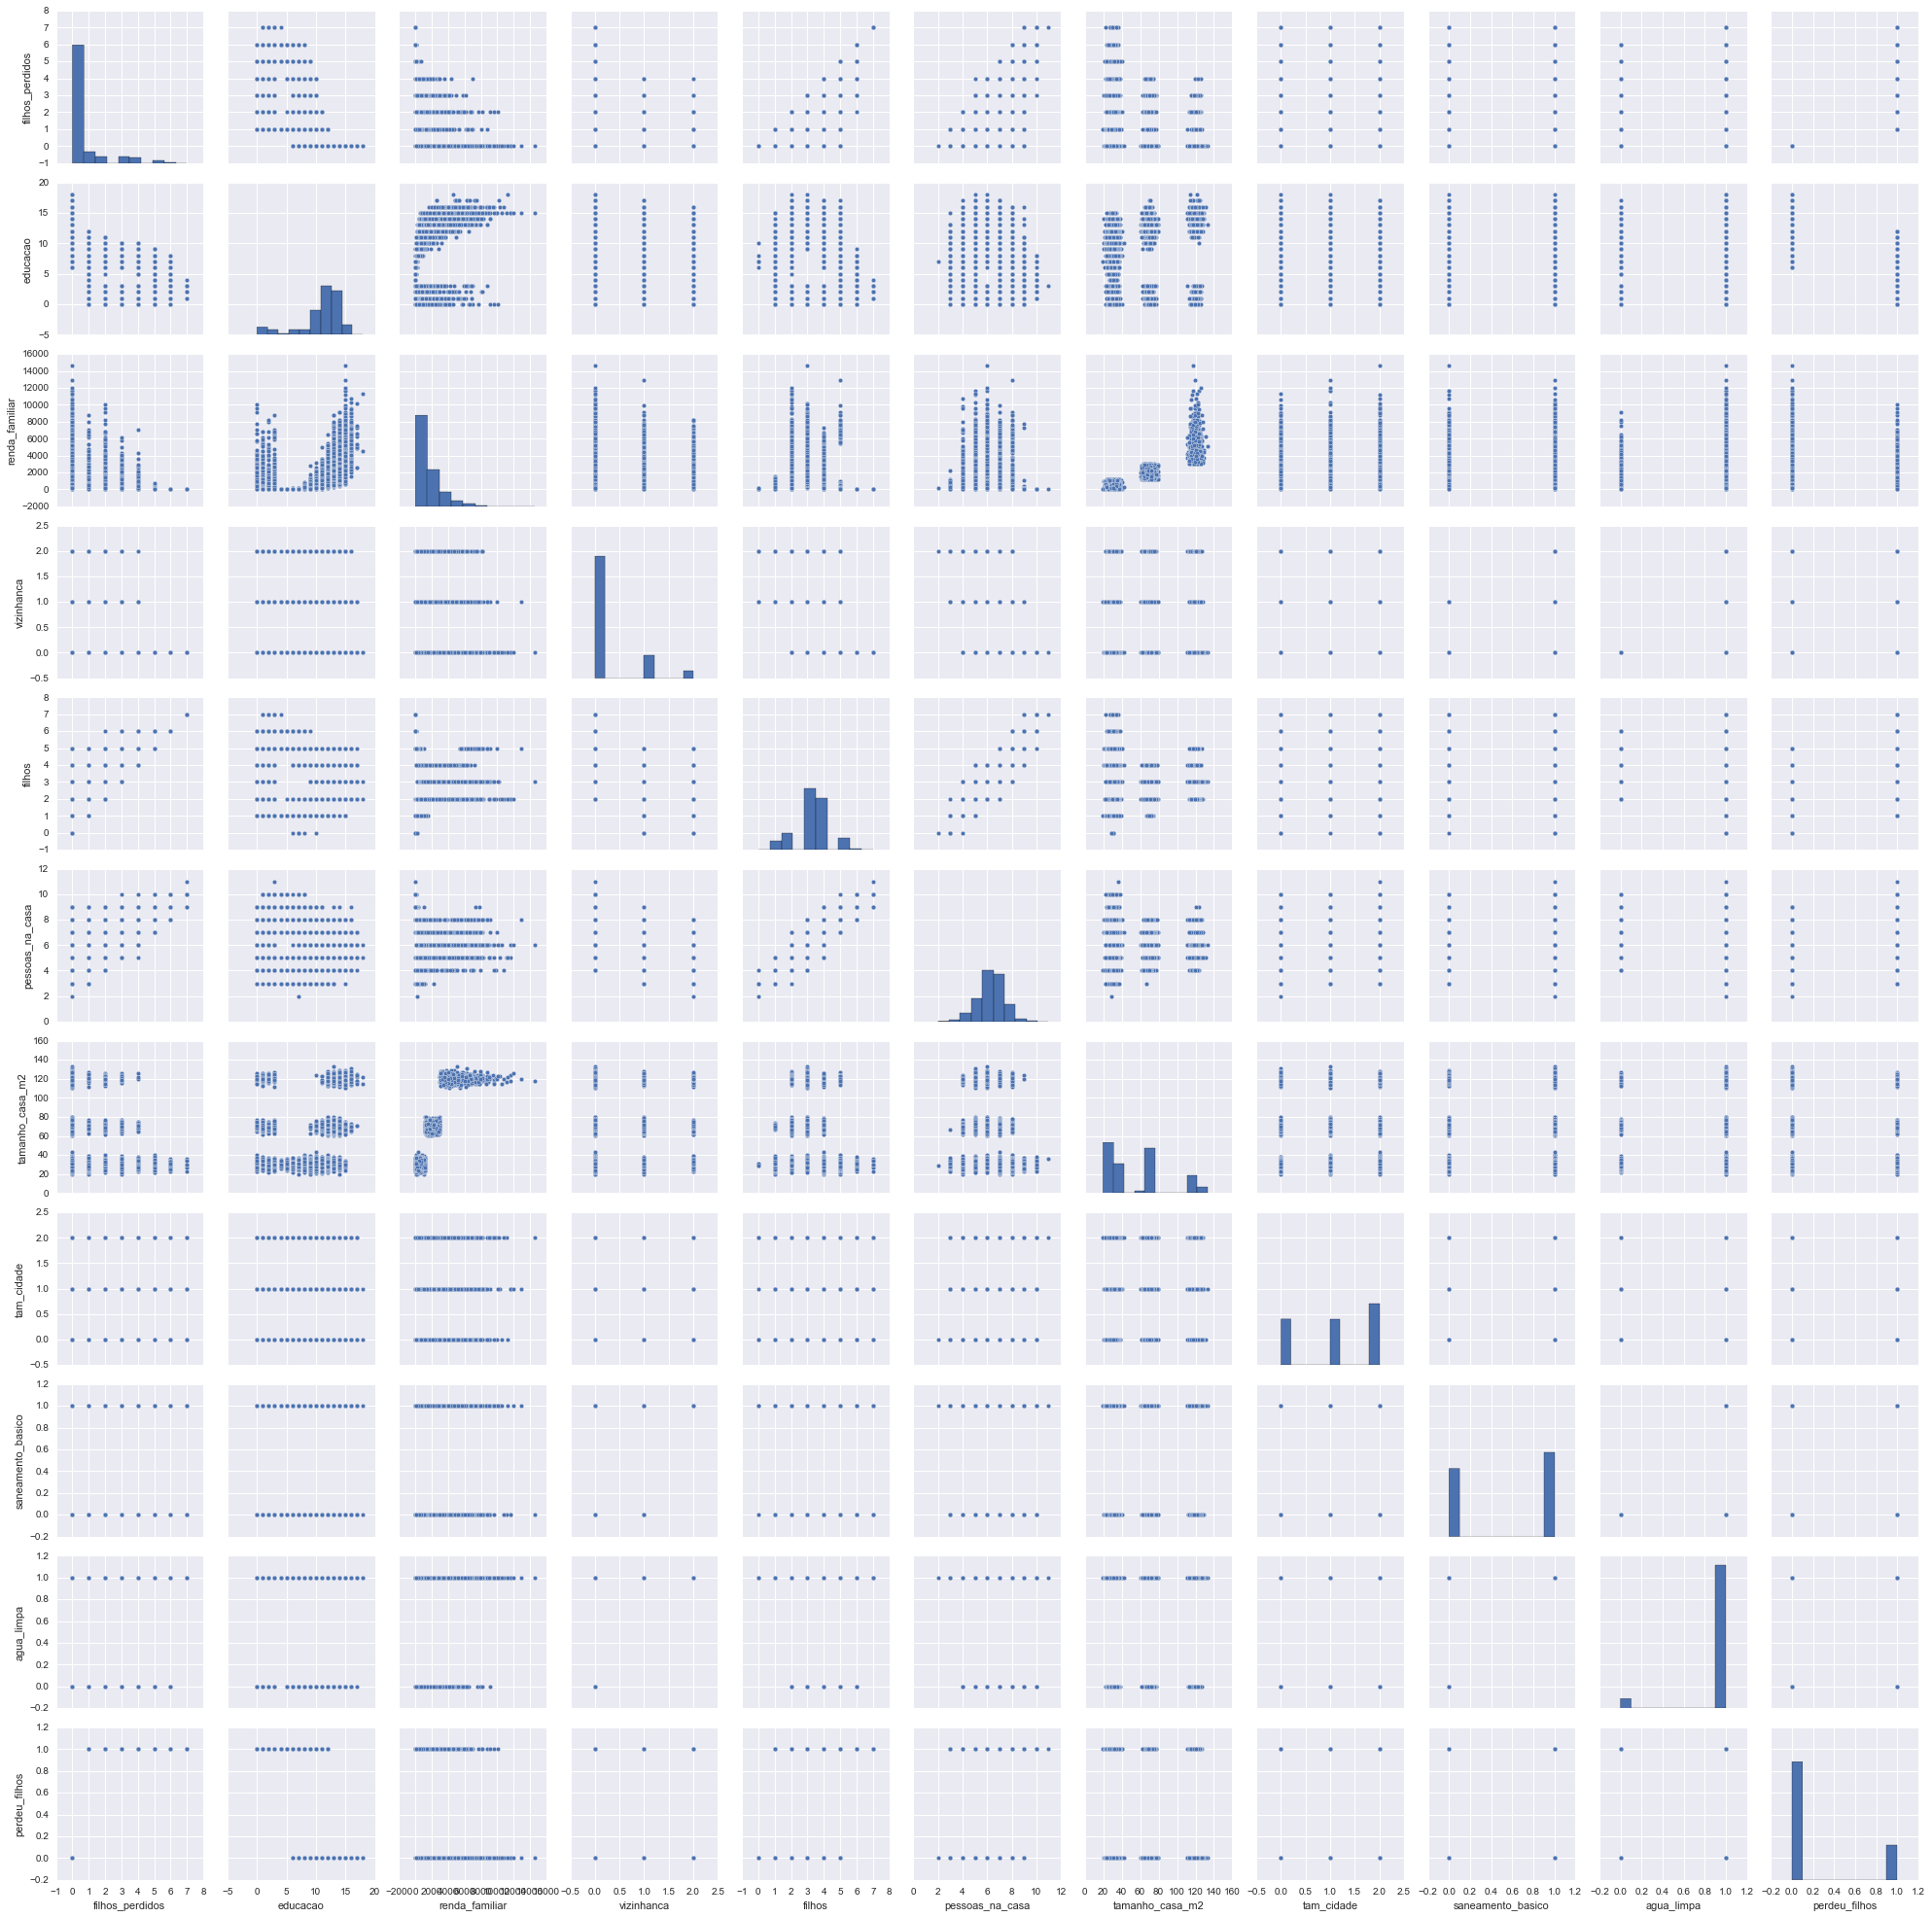

In [9]:
sns.pairplot(df)

Pode-se notar que o fator de *renda_familiar* parece seguir uma distribuição exponencial e, dado o range de valores observados nas estatísticas da célula 3 acima, usaremos o logaritmo desse fator como um termo do modelo. 

## Análise de correlações

In [10]:
correlations = df.corr()
correlations

,filhos_perdidos,educacao,renda_familiar,vizinhanca,filhos,pessoas_na_casa,tamanho_casa_m2,tam_cidade,saneamento_basico,agua_limpa,perdeu_filhos
filhos_perdidos,1.000000,-0.742167,-0.279382,-0.143840,0.446224,0.393161,-0.251917,0.004067,-0.168571,-0.109735,0.837408
educacao,-0.742167,1.000000,0.397642,0.003470,-0.184575,-0.162647,0.380928,-0.000317,-0.014461,-0.018673,-0.753551
renda_familiar,-0.279382,0.397642,1.000000,0.007674,-0.221962,-0.195073,0.888176,0.002805,-0.013598,0.012063,-0.304338
vizinhanca,-0.143840,0.003470,0.007674,1.000000,-0.571961,-0.505948,0.005583,-0.000898,0.156471,0.120489,-0.108847
filhos,0.446224,-0.184575,-0.221962,-0.571961,1.000000,0.872325,-0.227116,-0.004308,-0.060650,-0.077973,0.345615
pessoas_na_casa,0.393161,-0.162647,-0.195073,-0.505948,0.872325,1.000000,-0.198964,0.000884,-0.057072,-0.066037,0.304608
tamanho_casa_m2,-0.251917,0.380928,0.888176,0.005583,-0.227116,-0.198964,1.000000,0.002222,-0.015448,0.000290,-0.285517
tam_cidade,0.004067,-0.000317,0.002805,-0.000898,-0.004308,0.000884,0.002222,1.000000,-0.002277,-0.009641,-0.002623
saneamento_basico,-0.168571,-0.014461,-0.013598,0.156471,-0.060650,-0.057072,-0.015448,-0.002277,1.000000,0.288246,-0.191226
agua_limpa,-0.109735,-0.018673,0.012063,0.120489,-0.077973,-0.066037,0.000290,-0.009641,0.288246,1.000000,-0.124627


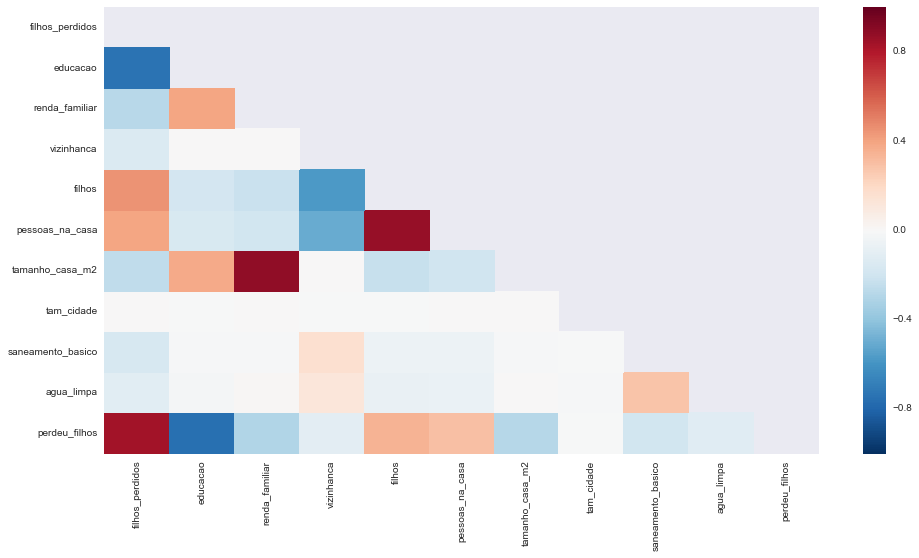

In [11]:
import numpy as np


mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlations, mask=mask)

Existe alta correlação entre renda familiar e tamanho da casa, e a correlação de ambos os fatores com a perda de filhos é semelhante - pode-se então remover o fator de tamanho da casa e preservar a informação de renda familiar para análise.

Da mesma forma, o número de filhos obviamente tem alta correlação com o número de pessoas na casa, então pode-se manter apenas a informação de número de filhos.

Renda familiar e educação possuem uma correlação em torno de 0.4, o que não seria suficiente para eliminar nenhum dos dois, logo ambos serão mantidos.

Já pode-se notar de imediato que a informação de tamanho da cidade não está correlacionada com nenhum fator e tampouco com a perda de filhos, então ela não será usada na análise.

In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=1234)
df_train.is_copy = None
df_test.is_copy = None
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

## Checagem de multicolinearidade

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

columns_to_consider = ['educacao', 'renda_familiar', 'vizinhanca', 'filhos', 'saneamento_basico', 'agua_limpa']
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_train[columns_to_consider].values, i) for i in range(df_train[columns_to_consider].shape[1])]
vif["features"] = df_train[columns_to_consider].columns

vif

,VIF Factor,features
0,9.357487,educacao
1,2.477147,renda_familiar
2,1.575337,vizinhanca
3,9.396267,filhos
4,2.461526,saneamento_basico
5,12.886784,agua_limpa


Alguns fatores apresentam um fator VIF alto, o que indica presença de multicolinearidade entre os fatores. Não usaremos então os fatores de *agua_limpa* e *filhos* na análise. Manteremos o fator *educação* devido à sua importância prática.

## Análise de regressão

In [14]:
import statsmodels.formula.api as smf
import numpy as np

model_ols = smf.logit('perdeu_filhos ~ educacao + np.log2(renda_familiar + 1) + saneamento_basico', data=df_train)
res = model_ols.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.089296
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:          perdeu_filhos   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7496
Method:                           MLE   Df Model:                            3
Date:                Sat, 21 Oct 2017   Pseudo R-squ.:                  0.8327
Time:                        14:03:37   Log-Likelihood:                -669.72
converged:                       True   LL-Null:                       -4004.3
                                        LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      31.1247      1.232     25.259      0.000  

In [15]:
from sklearn.metrics import classification_report

train_probabilities = res.predict(df_train[['educacao', 'renda_familiar', 'saneamento_basico']])
test_probabilities = res.predict(df_test[['educacao', 'renda_familiar', 'saneamento_basico']])

print('Classification report for training data:')
print(classification_report(df_train['perdeu_filhos'], train_probabilities > 0.5))
print('Classification report for test data:')
print(classification_report(df_test['perdeu_filhos'], test_probabilities > 0.5))

Classification report for training data:
             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98      5808
        1.0       0.94      0.91      0.92      1692

avg / total       0.96      0.96      0.96      7500

Classification report for test data:
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      1941
        1.0       0.94      0.92      0.93       559

avg / total       0.97      0.97      0.97      2500



Na análise acima, pode-se ver que todos os fatores são estatisticamente significativos (em termos de p-values) e que as métricas de classificação obtidas pela regressão logística são satisfatórias.

Podemos exponenciar os coeficientes obtidos para saber qual é o fator de crescimento de chances associado a cada termo do modelo obtido:

In [16]:
np.exp(res.params)

Intercept                      3.290777e+13
educacao                       1.769650e-01
np.log2(renda_familiar + 1)    2.322594e-01
saneamento_basico              1.398322e-03
dtype: float64

Pelos resultados acima, podemos ver que, fixados os demais fatores, pode-se esperar que as chances de uma família perder filhos sejam reduzidas de:
- 1/0.1769650 ~= **5.65 vezes** para cada ano adicional de **educação**;
- 1/0.2322594 ~= **4.3 vezes** quando se dobra a **renda familiar**;
- 1/0.001398322 ~= **715 vezes** pela presença de **saneamento básico**;

## Análise de curva CAP

Para avaliar quantas famílias devem ser abordadas segundo o modelo que foi gerado, vamos fazer uma análise de curva CAP (Cumulative Accuracy Profile) para entender qual porcentagem das famílias em risco nosso modelo permite abordar.

In [17]:
df_test.loc[:, 'probabilidade_prevista'] = test_probabilities
df_test.loc[:, 'palpite_filho_perdido'] = 0.0
df_test.loc[df_test['probabilidade_prevista'] > 0.5, 'palpite_filho_perdido'] = 1.0
df_test_sorted = df_test.sort_values('probabilidade_prevista', ascending=False)

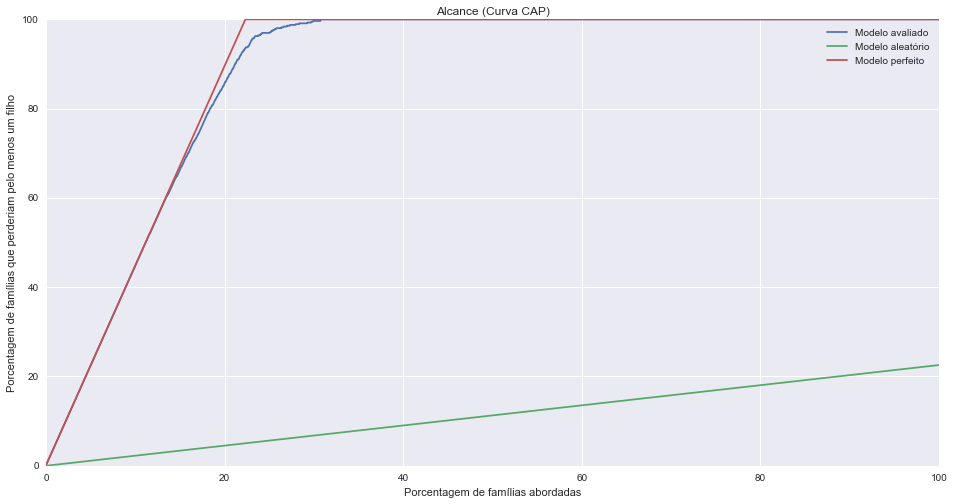

In [18]:
num_families_that_lost_children = df_test['perdeu_filhos'].sum()
sums_of_families_that_lost_children = df_test_sorted['perdeu_filhos'].cumsum().values

x_values = np.asarray(range(len(df_test))) / len(df_test) * 100.0
y_values = np.zeros(len(df_test))
for i in range(len(df_test)):
    y_values[i] = sums_of_families_that_lost_children[i] / num_families_that_lost_children
y_values *= 100.0

axes = plt.gca()

plt.plot(x_values, y_values)
plt.plot(x_values, x_values * 0.22559)
plt.plot(x_values, df_test.sort_values('perdeu_filhos', ascending=False)['perdeu_filhos'].cumsum() / num_families_that_lost_children * 100.0)
plt.title('Alcance (Curva CAP)')
plt.xlabel('Porcentagem de famílias abordadas')
plt.ylabel('Porcentagem de famílias que perderiam pelo menos um filho')
plt.legend(['Modelo avaliado', 'Modelo aleatório', 'Modelo perfeito']);

Segundo a curva acima, o modelo gerado permitiria alcançar mais de 80% das famílias em risco abordando apenas 20% do total de famílias.